### Imports

In [8]:
from langchain_core.messages import AIMessage, BaseMessage
from langgraph.graph.message import add_messages
from typing import Annotated, Sequence, TypedDict

from dotenv import load_dotenv
load_dotenv()#'../.env')

from Tools_r2 import get_news, currency_converter, ddg_search

### Model Instantiation

In [9]:
from langchain_groq.chat_models import ChatGroq
llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")

In [10]:
llm.invoke("what's the top world news?")

AIMessage(content="Here are the top world news stories currently trending:\n\n**1.** **Russia-Ukraine Conflict:** The situation in Ukraine remains tense as Russian forces continue to build up along the border. The US and its allies have imposed sanctions on Russia, and NATO has deployed troops to Eastern Europe. Diplomatic efforts are underway to prevent a full-scale war.\n\n**2.** **COVID-19 Pandemic:** The Omicron variant continues to spread globally, with many countries experiencing surges in cases and hospitalizations. Governments are reimposing restrictions, and vaccine distribution efforts are ongoing.\n\n**3.** **Myanmar Coup:** The military junta in Myanmar (Burma) has cracked down on pro-democracy protests, leading to widespread violence and international condemnation. The UN has called for the release of detained leaders, including Aung San Suu Kyi.\n\n**4.** **Iran Nuclear Talks:** Diplomatic efforts to revive the 2015 Iran nuclear deal are ongoing in Vienna. The US, Iran, a

### Making tools compatible with LangGraph

In [11]:
from langchain_core.tools import tool
# doc strings are mendatory in langgraph

@tool
def currency_converter_lg(
    amount: Annotated[str, "Amount of currency in base_currency"],
    base_currency: Annotated[str, "Base_currency symbol"] = "USD",
    quote_currency: Annotated[str, "Quote currency symbol"] = "GBP",
) -> str:
    """AI is creating summary for currency_converter_lg

    Args:
        amount (Annotated[str,): [description]
        base_currency (Annotated[str,, optional): [description]. Defaults to "USD".
        quote_currency (Annotated[str,, optional): [description]. Defaults to "GBP".

    Returns:
        str: [description]
    """
    result = currency_converter(amount, base_currency, quote_currency)
    return result

@tool
def ddg_search_lg(
    topic: Annotated[str, "Topic to search for news"]="world news",
    num_headlines: Annotated[int, "Number of headlines to return"] = 5,
    )-> str:
    """AI is creating summary for ddg_search_lg

    Args:
        topic (Annotated[str,, optional): [description]. Defaults to "world news".
        num_headlines (Annotated[int,, optional): [description]. Defaults to 5.

    Returns:
        str: [description]
    """
    search_results = ddg_search(topic, num_headlines)
    return search_results
 
@tool
def get_news_lg(
    topic: Annotated[str, "Topic to search for news"]="world news",
    num_headlines: Annotated[int, "Number of headlines to return"] = 5,
    )-> str:
    """AI is creating summary for get_news_lg

    Args:
        topic (Annotated[str,, optional): [description]. Defaults to "world news".
        num_headlines (Annotated[int,, optional): [description]. Defaults to 5.

    Returns:
        str: [description]
    """
    news_results = get_news(topic, num_headlines)
    return news_results

tools = [currency_converter_lg, ddg_search_lg, get_news_lg]
model = llm.bind_tools(tools)  # this is important, we have similar thing in Autogen

### Initializaing agent-state, defining tool_node, agent_node 

In [12]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

tools_by_name = {tool.name: tool for tool in tools}  # same as tools dictionary 


# Define our tool node, that calls the tools
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state['messages'][-1].tool_calls:  # calling any tools found in message state.
        tool_result = tools_by_name[tool_call["name"]].invoke(
            tool_call["args"]
        )
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}
# The tool node function is now pre-built in langgraph
#from langgraph.prebuilt import ToolNode
#tool_node = ToolNode(tools)

# Define the agent node that calls the model
def agent_node(state: AgentState, config: RunnableConfig,):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage("You are an intelligent agent capable of answering questions and performing tasks using the tools you have been provided.")
    response = model.invoke([system_prompt] + state['messages'], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if last_message.tool_calls:
        return "tools"
    # Otherwise if there is, we continue
    else:
        return "end"

### Define Graph, Adding Nodes and Edges

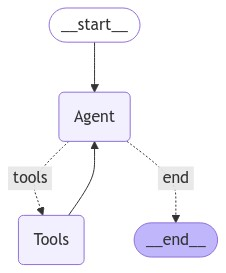

In [13]:
from langgraph.graph import StateGraph, END
from langgraph.constants import END

######################## Defining Graph ######################
# Define a new graph
workflow = StateGraph(AgentState)

######################## Defining Nodes ######################
# Define the two nodes we will cycle between
workflow.add_node("Agent", agent_node)
workflow.add_node("Tools", tool_node)

######################## Defining Edges ######################
# Set the entrypoint as `agent` (this node is the first one called)
workflow.add_edge("__start__", "Agent")  #same as workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "Agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,  
    # Based on if the last message in the state has tools call or END (final answer obtained).
    {   
        "tools": "Tools",  # If `tools` in last message, then we call the tool_node.
        "end": END,        # Otherwise 'END' a special node marking that the graph should finish.
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("Tools", "Agent")

######################## Compiling Graph ######################
# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

query = """"What's are the top 10 the latest news about AI (list in bullets)
and how much is 100 USD in EUR?"""

inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

"What's are the top 10 the latest news about AI (list in bullets)
and how much is 100 USD in EUR?
================================== Ai Message ==================================
Tool Calls:
  get_news_lg (call_ntgn)
 Call ID: call_ntgn
  Args:
    topic: AI
    num_headlines: 10
  currency_converter_lg (call_azhd)
 Call ID: call_azhd
  Args:
    amount: 100
    base_currency: USD
    quote_currency: EUR
-> TOOL-CURRENCY_CONVERTER CALLED
================================= Tool Message =================================
Name: currency_converter_lg

92.10000000000001
================================== Ai Message ==================================

Here is the response:

The top 10 latest news about AI are:

* The Age of AI Child Abuse Is Here
* Big Tech Has Given Itself an AI Deadline
* AI Chatbots Behind The Latest Memecoin Trend
* Meta releases AI model that can check other AI models' work
* AI Startup Sand